# Cong Workbook


### Import Libraries

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [95]:
!pip install mysql-connector-python

In [96]:
import mysql.connector

In [97]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Loading SQL Queries

In [98]:
tn = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tn_movie_budgets""", con))

In [99]:
#Change data types
tn['domestic_gross'] = tn['domestic_gross'].str.replace('$','')  
tn['domestic_gross'] = tn['domestic_gross'].str.replace(',','')
tn['domestic_gross'] = tn['domestic_gross'].astype(float)
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace('$','')
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace(',','')
tn['worldwide_gross'] =tn['worldwide_gross'].astype(float) 
tn['production_budget'] =tn['production_budget'].str.replace('$','')
tn['production_budget'] =tn['production_budget'].str.replace(',','')
tn['production_budget'] =tn['production_budget'].astype(float) 
tn['release_date'] = pd.to_datetime(tn['release_date'])

In [100]:
bom = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.bom_movie_gross""", con))

In [101]:
tmd = pd.DataFrame(pd.read_sql_query("""
SELECT
	title,
    vote_average,
    popularity,
    release_date
FROM movies.tmdb_movies""", con))

In [102]:
tmd['release_date'] = pd.to_datetime(tmd['release_date'])

In [103]:
tmd = tmd.drop_duplicates(subset='title',keep=False)

In [104]:
imdb_title_basics = pd.DataFrame(pd.read_sql_query("""
SELECT 
	primary_title,
    genres,
    start_year
FROM movies.imdb_title_basics""", con))

In [105]:
imdb_title_basics['title_new'] = imdb_title_basics['primary_title'].apply(lambda x: x.replace(' ',''))
imdb_title_basics['title_new'] = imdb_title_basics['title_new'].apply(lambda x: x.lower())
imdb_title_basics['title_new_year'] = imdb_title_basics['title_new'] + imdb_title_basics['start_year'].astype(str)

In [106]:
# SELECT *
# FROM movies.imdb_title_basics
# JOIN movies.imdb_title_ratings USING (tconst)
#to compare ImDB genre to ratings 

In [107]:
# SELECT
# 	nconst,
#     tconst,
#     ordering,
#     category,
#     primary_title,
#     start_year,
#     genres,
#     primary_name,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_principals
# JOIN movies.imdb_title_basics USING (tconst)
# JOIN movies.imdb_name_basics USING (nconst)
# JOIN movies.imdb_title_ratings USING (tconst)
# WHERE start_year >= 2015
#to show which actresses / actors / directors appeared in most highly rated movies since 2015

In [108]:
# tn = pd.DataFrame(pd.read_sql_query("""
# SELECT Count(*)
# 	tconst,
#     primary_title,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_ratings
# JOIN movies.imdb_title_basics USING (tconst)""", con))
# to join with tbi to get ratings vs. box office success correlation

### Worldwide Gross by Genre and Season

In [109]:
# JOIN bom and tn
tb = tn.join(bom.set_index('title'),
             on='movie',
             how='outer',
             lsuffix='_tn',
             rsuffix='_bom')

In [110]:
# JOIN tb with tmd
tbt = tb.join(
        tmd.set_index('title'),
        on='movie',
        how='left',
        rsuffix='_tmd')

In [111]:
tbt['release_date'] = np.where(tbt['release_date'].isna(), tbt['release_date_tmd'], tbt['release_date']) 

In [112]:
tbt = tbt.drop(columns='release_date_tmd')

In [113]:
tbt['year'] = np.where(tbt['release_date'].isna(), tbt['year'], tbt['release_date'].dt.year)
tbt['movie_new'] = tbt['movie'].apply(lambda x: x.replace(' ',''))
tbt['movie_new'] = tbt['movie_new'].apply(lambda x: x.lower())
tbt['movie_new_year'] = tbt['movie_new'] + tbt['year'].astype(str)
tbt['movie_new_year'] = tbt['movie_new_year'].apply(lambda x: x.replace('.0','')) 

In [114]:
# JOIN tbt with imdb_title_basics
tbi = tbt.join(imdb_title_basics.set_index('title_new_year'),
        on='movie_new_year',
        how='left',
        rsuffix='_imdb')

In [115]:
tbi = tbi.drop_duplicates(subset = 'movie')

In [116]:
tbi['domestic_gross_tn'] = np.where(tbi['domestic_gross_tn'].isna(), tbi['domestic_gross_bom'], tbi['domestic_gross_tn']) 
tbi = tbi.drop(columns=['domestic_gross_bom','studio'])
tbi['release_month'] = tbi['release_date'].dt.month
tbi = tbi.rename(columns={'production_budget':'production_budget_$m','domestic_gross_tn':'domestic_gross_$m','worldwide_gross':'worldwide_gross_$m', 'foreign_gross':'foreign_gross_$m'})

In [117]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))

In [118]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].astype(float)
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].astype(float)
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].astype(float)
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].astype(float)

In [119]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['global_mom'] = tbi['worldwide_gross_$m'] / tbi['production_budget_$m']
tbi = tbi.round({'global_mom':2})

In [120]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['release_month'] = tbi['release_date'].dt.month

In [121]:
tbi['worldwide_gross_$m'] = np.where(tbi['worldwide_gross_$m'].isna(), tbi['domestic_gross_$m'] + tbi['foreign_gross_$m'], tbi['worldwide_gross_$m'])

In [122]:
tbi = tbi.drop(columns=['year','start_year','movie_new'])

In [123]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    5698 non-null   float64       
 1   release_date          6663 non-null   datetime64[ns]
 2   movie                 7846 non-null   object        
 3   production_budget_$m  5698 non-null   float64       
 4   domestic_gross_$m     7820 non-null   float64       
 5   worldwide_gross_$m    6630 non-null   float64       
 6   foreign_gross_$m      2037 non-null   float64       
 7   vote_average          2571 non-null   float64       
 8   popularity            2571 non-null   float64       
 9   movie_new_year        7846 non-null   object        
 10  primary_title         2467 non-null   object        
 11  genres                2467 non-null   object        
 12  title_new             2467 non-null   object        
 13  release_month  

In [133]:
tbi['movie_new_year']

0.0                                   avatar2009
1.0    piratesofthecaribbean:onstrangertides2011
2.0                              darkphoenix2019
3.0                     avengers:ageofultron2015
4.0              starwarsep.viii:thelastjedi2017
                         ...                    
NaN                                 thequake2018
NaN                 edwardii(2018re-release)2018
NaN                                  elpacto2018
NaN                                  theswan2018
NaN                          anactorprepares2018
Name: movie_new_year, Length: 7846, dtype: object

In [136]:
tbi_genre= pd.DataFrame(tbi.genres.str.split(',').tolist(), index=tbi.movie).stack()

In [137]:
tbi_genre =tbi_genre.reset_index([0, 'movie'])

In [139]:
tbi_genre = tbi_genre.join(tbi.set_index('movie'),on='movie')

In [141]:
tbi_genre = tbi_genre.rename(columns={0:'genre'})

In [142]:
tbi_genre = tbi_genre.explode('genre')

In [146]:
tbi_genre = tbi_genre.drop(columns='genres')

KeyError: "['genres'] not found in axis"

In [148]:
tbi_genre['release_month'] = tbi_genre['release_date'].dt.month

In [149]:
tbi['release_month'] = tbi['release_date'].dt.month

### Execution

In [42]:
import seaborn as sns

In [43]:
tbi_since1990 = tbi_genre.loc[tbi_genre['release_year'] > 1989]

In [44]:
tbi_since1990.groupby(['genre']).mean()

,id,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,vote_average,popularity,release_month,release_year,global_mom
genre,,,,,,,,,,
Action,50.615385,79.127473,72.541301,227.043053,160.816489,6.129218,14.662453,6.820244,2014.089005,2.618996
Adventure,47.550279,105.935754,109.030660,328.878412,228.162500,6.306647,16.906202,7.047059,2014.331765,3.066011
Animation,44.405660,96.716981,112.461538,338.243697,244.581633,6.322642,14.023340,7.238462,2014.438462,3.614528
Biography,52.194030,25.701493,28.573604,72.301887,50.165138,6.760784,9.686935,8.578680,2014.736041,inf
Comedy,50.436673,40.455577,45.467852,123.198098,87.828633,6.115470,10.354233,7.188525,2013.571038,inf
Crime,49.525862,32.806034,30.524590,81.138996,46.088889,6.216791,11.527896,7.186275,2013.970588,inf
Documentary,49.416667,8.750000,5.243478,17.142857,12.567568,6.966990,4.916913,7.413793,2013.241379,inf
Drama,51.208564,26.628453,23.679193,66.765714,48.074523,6.408681,9.441171,7.748858,2013.857534,inf
Family,54.288660,65.835052,69.750000,183.405941,101.449275,6.160227,11.110864,7.546296,2013.564815,2.610745


In [45]:
genre_vs_mom = tbi_since1990.groupby(['genre']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [46]:
genre_vs_mom

genre
Mystery        3.250
Animation      2.980
Sci-Fi         2.780
Horror         2.670
Adventure      2.620
Music          2.500
Thriller       2.400
Comedy         2.350
Romance        2.330
Documentary    2.315
Fantasy        2.180
Action         2.135
Family         2.015
Biography      2.000
Drama          1.900
History        1.810
Sport          1.745
Crime          1.650
Musical        0.870
Western        0.725
War            0.665
News             NaN
Name: global_mom, dtype: float64

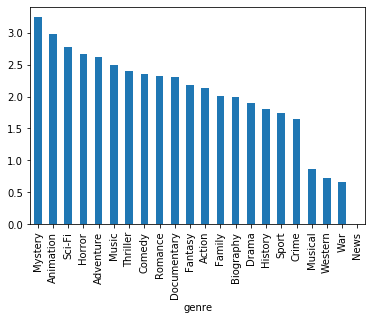

In [47]:
genre_vs_mom.plot.bar()

In [48]:
genre_vs_mom = genre_vs_mom.reset_index()

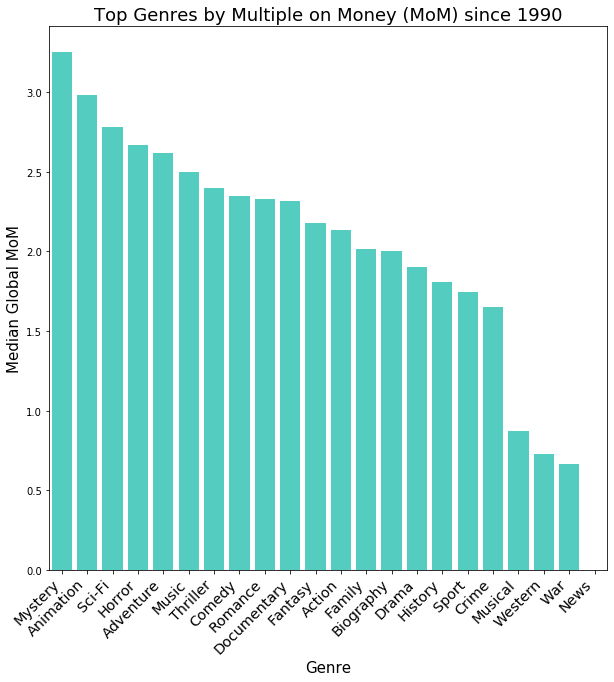

In [49]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='global_mom',data=genre_vs_mom, ci=None, color = 'turquoise')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Global MoM", size=15)
plt.title("Top Genres by Multiple on Money (MoM) since 1990", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [50]:
tbi_genre.groupby(['genre']).mean()

,id,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,vote_average,popularity,release_month,release_year,global_mom
genre,,,,,,,,,,
Action,50.615385,79.127473,65.111614,221.773551,155.880096,6.129218,14.662453,6.820244,2014.089005,2.618996
Adventure,47.550279,105.935754,106.026432,325.447867,224.020649,6.306647,16.906202,7.047059,2014.331765,3.066011
Animation,44.405660,96.716981,109.049645,328.456693,232.811321,6.322642,14.023340,7.238462,2014.438462,3.614528
Biography,52.194030,25.701493,25.399123,68.571429,46.632000,6.760784,9.686935,8.578680,2014.736041,inf
Comedy,50.436673,40.455577,40.270047,119.637574,84.447732,6.115470,10.354233,7.188525,2013.571038,inf
Crime,49.525862,32.806034,27.465909,77.569395,43.162562,6.216791,11.527896,7.186275,2013.970588,inf
Documentary,49.416667,8.750000,4.532374,16.426471,11.595238,6.966990,4.916913,7.413793,2013.241379,inf
Drama,51.208564,26.628453,20.816471,65.822460,47.526562,6.408681,9.441171,7.748858,2013.857534,inf
Family,54.288660,65.835052,68.369748,186.750000,104.441558,6.160227,11.110864,7.546296,2013.564815,2.610745


In [51]:
genre_vs_mom_all = tbi_genre.groupby(['genre']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [52]:
genre_vs_mom_all = genre_vs_mom_all.reset_index()

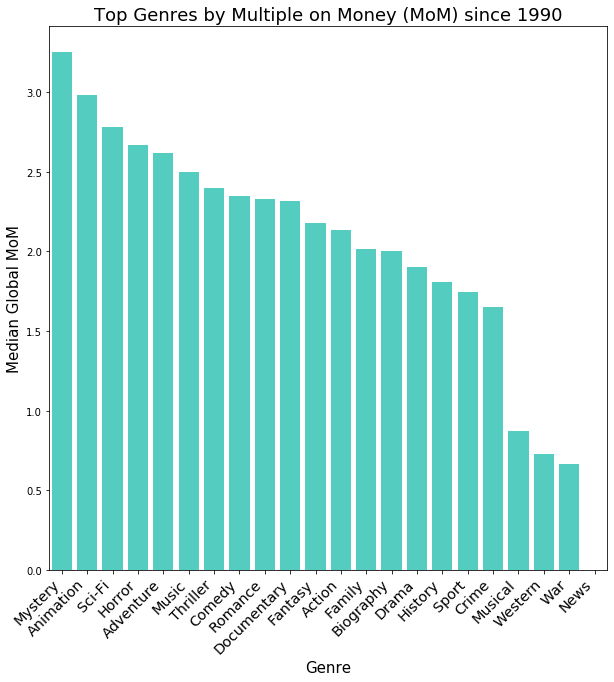

In [53]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='global_mom',data=genre_vs_mom_all, ci=None, color = 'turquoise')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Global MoM", size=15)
plt.title("Top Genres by Multiple on Money (MoM) since 1990", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [54]:
genre_vs_wwg_all = tbi_genre.groupby(['genre']).median().sort_values(by='worldwide_gross_$m',ascending=False)['worldwide_gross_$m']

In [55]:
genre_vs_wwg_all = genre_vs_wwg_all.reset_index()

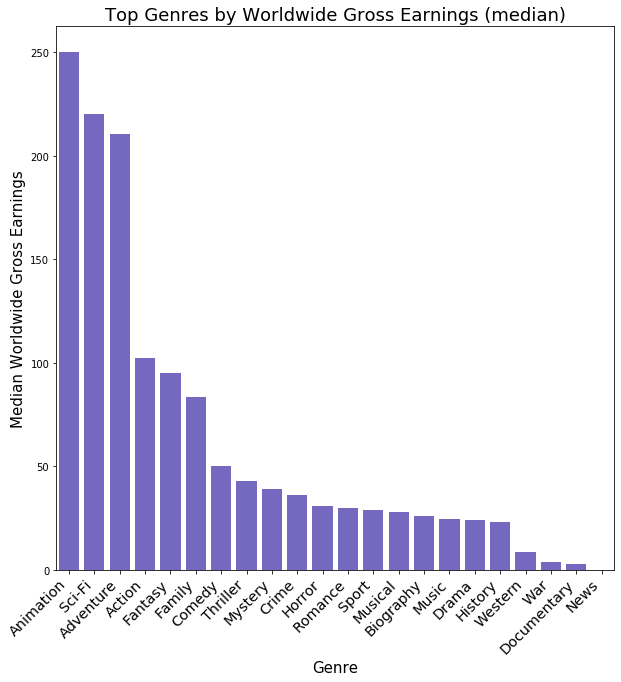

In [56]:
plt.figure(figsize=(10, 10))
chart = sns.barplot(x='genre',y='worldwide_gross_$m',data=genre_vs_wwg_all, ci=None, color = 'slateblue')

# set labels
plt.xlabel("Genre", size=15)
plt.ylabel("Median Worldwide Gross Earnings", size=15)
plt.title("Top Genres by Worldwide Gross Earnings (median)", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [57]:
mom_by_month = tbi.groupby(['release_month']).median().sort_values(by='release_month',ascending=True)['global_mom']

In [58]:
mom_by_month = mom_by_month.reset_index()

In [59]:
mom_by_month = mom_by_month.replace(to_replace = 12.0,value='December')
mom_by_month = mom_by_month.replace(to_replace = 11.0,value='November')
mom_by_month = mom_by_month.replace(to_replace = 10.0,value='October')
mom_by_month = mom_by_month.replace(to_replace = 9.0,value='September')
mom_by_month = mom_by_month.replace(to_replace = 8.0,value='August')
mom_by_month = mom_by_month.replace(to_replace = 7.0,value='July')
mom_by_month = mom_by_month.replace(to_replace = 6.0,value='June')
mom_by_month = mom_by_month.replace(to_replace = 5.0,value='May')
mom_by_month = mom_by_month.replace(to_replace = 4.0,value='April')
mom_by_month = mom_by_month.replace(to_replace = 3.0,value='March')
mom_by_month = mom_by_month.replace(to_replace = 2.0,value='February')
mom_by_month = mom_by_month.replace(to_replace = 11.0,value='January')


In [60]:
mom_by_month

,release_month,global_mom
0,1,1.590
1,February,1.750
2,March,1.630
3,April,1.455
4,May,2.180
5,June,2.260
6,July,2.400
7,August,1.730
8,September,1.330
9,October,1.500


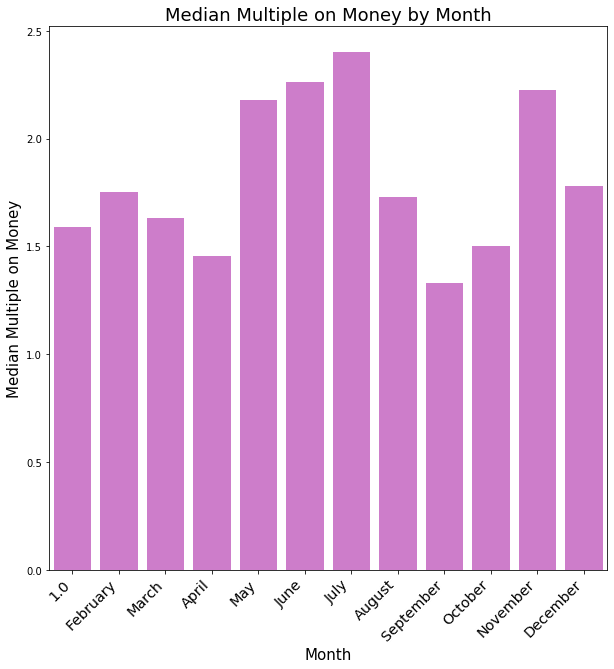

In [61]:

plt.figure(figsize=(10, 10))
chart = sns.barplot(x='release_month',y='global_mom',data=mom_by_month, color='orchid',ci=None)

# set labels
plt.xlabel("Month", size=15)
plt.ylabel("Median Multiple on Money", size=15)
plt.title("Median Multiple on Money by Month", size=18)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

### Notes

In [ ]:
# Use below three tables to do earnings / ROI by genre by season

In [ ]:
SELECT COUNT(*) 
FROM movies.imdb_title_basics
WHERE start_year > 2010
#total 146144 rows --> starts 2010 only 

In [ ]:
SELECT COUNT(*)
FROM movies.bom_movie_gross
# total 3387 rows --> total database only has 3387 rows and starts at 2010

In [ ]:
# tn movie budgets; bom movie gross; tmbd movies with unique titles 

In [ ]:
SELECT 
	COUNT(*),
    RIGHT(release_date, 4)
FROM movies.tn_movie_budgets
GROUP BY RIGHT(release_date, 4) ASC
#5782 rows total --> 1996 first year with over 100 movies 

SELECT 
	COUNT(*)
FROM movies.tn_movie_budgets
WHERE RIGHT(release_date, 4) > 1995
#4925
#2194 for 2010 and after

In [1]:
#GENERAL Analysis (JOIN ON Movie name)
#earnings / ROI by genre (tn_movie_budgets + imdb_title_basics JOIN on movie title) POST 2010 (only 2194 movies)
#earnings / ROI by season (use only tn_movie_budgets) POST 2010 (only 2194 movies)
#ratings vs. box office success correlatoin (movie_budgets and title_basics)
#IMDB analysis (JOIN ON nmstat and tstat)
#imdb genre vs. rating (use title_basics, title_ratings JOIN on tconst) POST 2010 (limit is ratings)
#imdb actors, directors and producers with highest ratings (use title_principals, title_ratings and 
#name_basics, JOIN on tconst and nmconst) POST 2010 (limit is ratings)
#RT Analysis (JOIN ON ID)
#overview of top critics, most frequent critics and what genres they like / how harsh they are (rt_reviews)
#rt ratings vs. box office reviews vs. top critics (1500 instances approx) limited by box office numbers in movie_info

In [ ]:
# LIST of databases
## DONT USE movies.bom_movie_gross for anything 
## DONT USE movies.imdb_name basics
## DONT USE imdb title akas
## DONT USE imdb title crew
## ONLY database with too many rows is imdb principles w/ over 1m 

In [ ]:
# TO DO
## Split genre into Primary, Secondary, Tertiary (for both ImDB and RT)